In [1]:
%matplotlib inline 
import itertools
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import sys

from collections import defaultdict
from sklearn import metrics

In [2]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [3]:
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocess import essay_documents, process_arg_essays_for_conll

In [7]:
ANNOTATIONS_DIR = '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/'
ANNOTATORS = {
    'mili': {'dirname': 'judgements-mili'},
    # 'laura': {'dirname': 'judgements-laura'},
    'serena': {'dirname': 'judgements-serena'}
}
ANNOTATION_FORMAT = r'.*\.ann'
BRAT_DIRNAME = '/home/milagro/FaMAF/am/third_party/brat/'
STYLES = {'claim': '__', 'major-claim': '***', 'premise': '`'}

### Find files to compare

In [11]:
def get_non_empty_files(input_dirpath, pattern, size_limit=500):
    """Returns the names of the files in input_dirpath matching pattern."""
    all_files = os.listdir(input_dirpath)
    result = {}
    for filename in all_files:
        if not re.match(pattern, filename):
            continue
        filepath = os.path.join(input_dirpath, filename)
        if os.path.isfile(filepath) and os.stat(filepath).st_size > 500:
            result[filename] = filepath
    return result

In [12]:
files = defaultdict(lambda: {})
for name, annotator in ANNOTATORS.items():
    annotator['files'] = get_non_empty_files(os.path.join(ANNOTATIONS_DIR, annotator['dirname']),
                                             ANNOTATION_FORMAT)
    for filename, filepath in annotator['files'].items():
        files[filename][name] = filepath

In [13]:
ANNOTATORS

{'mili': {'dirname': 'judgements-mili',
  'files': {'CASE_OF__ALKASI_v._TURKEY.ann': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__ALKASI_v._TURKEY.ann',
   'CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann'}},
 'serena': {'dirname': 'judgements-serena',
  'files': {'CASE_OF__ALKASI_v._TURKEY.ann': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-serena/CASE_OF__ALKASI_v._TURKEY.ann'}}}

In [14]:
dict(files)

{'CASE_OF__ALKASI_v._TURKEY.ann': {'mili': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__ALKASI_v._TURKEY.ann',
  'serena': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-serena/CASE_OF__ALKASI_v._TURKEY.ann'},
 'CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann': {'mili': '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann'}}

Find pairs of files annotated for more than one annotator.

In [15]:
from imp import reload
reload(process_arg_essays_for_conll)
reload(essay_documents)

<module 'preprocess.essay_documents' from '/home/milagro/am/argument_mining/preprocess/essay_documents.py'>

In [17]:
document_pairs = []
for value in files.values():
    if len(value) < 2:
        continue
    annotations = {}
    for name, filename in value.items():
        identifier = 'Case: {} - Ann: {}'.format(
            os.path.basename(filename[:-4]).replace('CASE_OF__', '').replace('_', ' '),
            name[0].title())
        with process_arg_essays_for_conll.EssayDocumentFactory(
                filename.replace('ann', 'txt'), identifier) as instance_extractor:
            annotations[name] = instance_extractor.build_document()
    for ann1, ann2 in list(itertools.combinations(annotations.keys(), 2)):
        document_pairs.append((annotations[ann1], annotations[ann2]))

In [18]:
document_pairs

[(Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: S)]

In [19]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [20]:
print(document_pairs[0][0].identifier)
printmd(document_pairs[0][0].sample_labeled_text(limit=35, styles=STYLES))
printmd('---')
print(document_pairs[0][1].identifier)
printmd(document_pairs[0][1].sample_labeled_text(limit=35, styles=STYLES))

Case: ALKASI v. TURKEY - Ann: M


Relying on Article 6 of the Convention , the applicant complains that __the__ __labour__ __court__ __’__ __s__ __dismissal__ __of__ __her__ __claim__ __for__ __compensation__ __against__ __her__ __former__ __employer__ __amounted__ __to__ __a__ __violation__ __of__ __her__ __right__ __to__ __be__ __presumed__ __innocent__ , in that `the` `labour` `court` `found` `that` `she` `had` `broken` `her` `employer` `’` `s` `trust` `by` `committing` `the` offence `of` `incitement` . 

The applicant argues that ***the*** ***labour*** ***court*** ***’*** ***s*** ***complete*** ***disregard*** ***of*** ***her*** ***acquittal*** ***in*** ***relation*** ***to*** ***the*** ***charge*** ***of*** ***incitement*** ***is*** ***incompatible*** ***with*** ***the*** ***requirements*** ***of*** ***Article*** ***6*** ***§*** ***2*** ***of*** ***the*** ***Convention*** . 

She further claims that __the__ __Bakırköy__ __Labour__ __Court__ __based__ __its__ __decision__ on __self-incriminating__ __statements__ __which__ __she__ __had__ __given__ __to__ __the__ __police__ __in__ __the__ __absence__ __of__ __her__ __lawyer__ . 

Being the master of the characterisation to be given in law to the facts of the case , the Court considers that __the__ __applicant__ __’__ __s__ __grievances__ __fall__ __to__ __be__ __examined__ __solely__ __under__ __Article__ __6__ __§__ __2__ __of__ __the__ __Convention__ which reads as follows : 



---

Case: ALKASI v. TURKEY - Ann: S


Relying on Article 6 of the Convention , the applicant complains that __the__ __labour__ __court__ __’__ __s__ __dismissal__ __of__ __her__ __claim__ __for__ __compensation__ __against__ __her__ __former__ __employer__ __amounted__ __to__ __a__ __violation__ __of__ __her__ __right__ __to__ __be__ __presumed__ __innocent__ , in that `the` `labour` `court` `found` `that` `she` `had` `broken` `her` `employer` `’` `s` `trust` `by` `committing` `the` offence `of` `incitement` . 

The applicant argues that ***the*** ***labour*** ***court*** ***’*** ***s*** ***complete*** ***disregard*** ***of*** ***her*** ***acquittal*** ***in*** ***relation*** ***to*** ***the*** ***charge*** ***of*** ***incitement*** ***is*** ***incompatible*** ***with*** ***the*** ***requirements*** ***of*** ***Article*** ***6*** ***§*** ***2*** ***of*** ***the*** ***Convention*** . 

She further claims that __the__ __Bakırköy__ __Labour__ __Court__ __based__ __its__ __decision__ on __self-incriminating__ __statements__ __which__ __she__ __had__ __given__ __to__ __the__ __police__ __in__ __the__ __absence__ __of__ __her__ __lawyer__ . 

Being the master of the characterisation to be given in law to the facts of the case , the Court considers that __the__ __applicant__ __’__ __s__ __grievances__ __fall__ __to__ __be__ __examined__ __solely__ __under__ __Article__ __6__ __§__ __2__ __of__ __the__ __Convention__ which reads as follows : 



# Compare document annotations

In [21]:
def show_kappa(labels1, labels2):
    kappa = metrics.cohen_kappa_score(labels1, labels2)
    print('{} - {}: {}'.format(
        doc1.identifier.split('-')[1].strip(),
        doc2.identifier.split('-')[1].strip(),
        kappa))

In [22]:
def show_confusion_matrix(labels1, labels2, identifier1=None, identifier2=None):
    label_names = list(set(labels1))
    matrix = metrics.confusion_matrix(labels1, labels2, labels=label_names)
    figure = sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5,
                         xticklabels=label_names, yticklabels=label_names)
    if identifier1 is not None:
        figure.set(ylabel=identifier1)
    if identifier2 is not None:
        figure.set(xlabel=identifier2)
    plt.show()

## Sentence level comparison

We compare the agreement on classifying argumentative vs non argumentative sentences

Ann: M - Ann: S: 0.5870206489675516


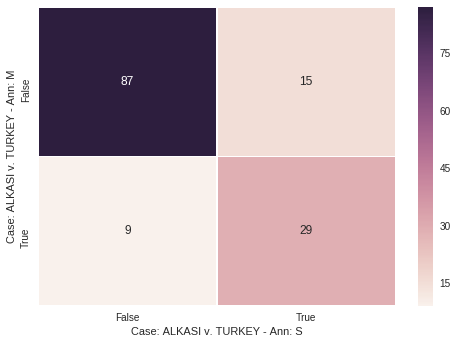

In [23]:
def get_argumentative_sentences(document):
    return [sentence.has_label for sentence in document.sentences]

for doc1, doc2 in document_pairs:
    labels1 = get_argumentative_sentences(doc1)
    labels2 = get_argumentative_sentences(doc2)
    show_kappa(labels1, labels2)
    show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

## Token level comparison

In [24]:
def get_labels(doc1, doc2):
    words1, labels1 = doc1.get_word_label_list()
    words2, labels2 = doc2.get_word_label_list()
    # Check the documents are equal
    assert words1 == words2
    return labels1, labels2

Kappa agreement using labels `claim`, `major-claim` and `premise`

Ann: M - Ann: S: 0.408810212320016


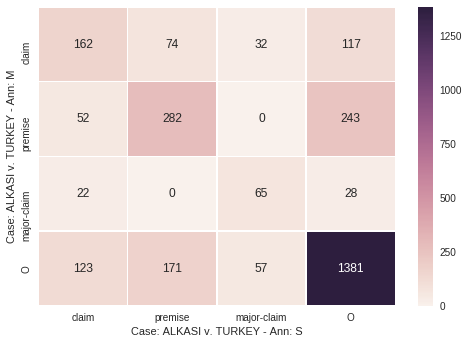

In [25]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = get_labels(doc1, doc2)
    show_kappa(labels1, labels2)
    show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

Kappa agreement using only labels `claim` and `premise`

Ann: M - Ann: S: 0.43042934425130475


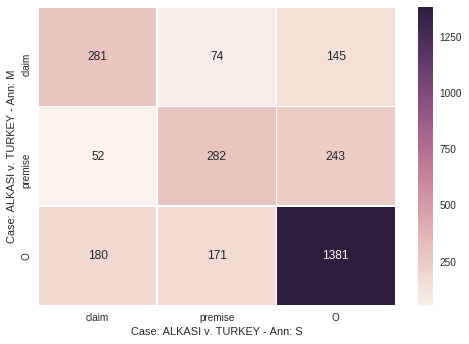

In [26]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = get_labels(doc1, doc2)
    labels1 = [x if x != 'major-claim' else 'claim' for x in labels1]
    labels2 = [x if x != 'major-claim' else 'claim' for x in labels2]
    show_kappa(labels1, labels2)
    show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

## Qualitative error analysis

In [27]:
def sample_sentences(doc1, doc2, label1, label2):
    """Samples sentences where label1 was confused with label2 in doc1 and doc2 respectively."""
    total_errors = 0
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        indices1 = [i for i, x in enumerate(sentence1.labels) if x == label1]
        if len(indices1) == 0:
            continue
        indices2 = [i for i, x in enumerate(sentence2.labels) if x == label2]
        if len(indices2) == 0 or len(set(indices1).intersection(indices2)) == 0:
            continue
        total_errors += len(set(indices1).intersection(indices2))
        # Print both sentences
        printmd(sentence1.pretty_print(styles=STYLES))
        printmd(sentence2.pretty_print(styles=STYLES))
        printmd('---')
    print('TOTAL ERRORS:', total_errors)

Examples labeled as `premise` in one document and as `O` in the other

In [33]:
print(document_pairs[0][0].identifier, document_pairs[0][1].identifier)

Case: ALKASI v. TURKEY - Ann: M Case: ALKASI v. TURKEY - Ann: S


In [28]:
sample_sentences(document_pairs[0][0], document_pairs[0][1], 'premise', 'O')

Viewed as a procedural guarantee in the context of a criminal trial itself , `the` `presumption` `of` `innocence` `imposes` `requirements` `in` `respect` `of` `,` `inter` `alia` `,` `the` `burden` `of` `proof` `,` `legal` `presumptions` `of` `fact` `and` `law` `,` `the` `privilege` `against` `self-incrimination` `,` `pre-trial` `publicity` `and` `premature` `expressions` `,` `by` `the` `trial` `court` `or` `by` `other` `public` `officials` `,` `of` `a` `defendant` `’` `s` `guilt` `(` `see` `Allen` `v.` `the` `United` `Kingdom` `[` `GC` `]` `,` `no` `.` 

Viewed as a procedural guarantee in the context of a criminal trial itself , __the__ __presumption__ __of__ __innocence__ __imposes__ __requirements__ __in__ __respect__ __of__ __,__ __inter__ __alia__ __,__ __the__ __burden__ __of__ __proof__ __,__ __legal__ __presumptions__ __of__ __fact__ __and__ __law__ __,__ __the__ __privilege__ __against__ __self-incrimination__ __,__ __pre-trial__ __publicity__ __and__ __premature__ __expressions__ __,__ __by__ __the__ __trial__ __court__ __or__ __by__ __other__ __public__ __officials__ __,__ __of__ __a__ __defendant__ __’__ __s__ __guilt__ ( see Allen v. the United Kingdom [ GC ] , no . 

---

`25424/09` `,` `§` `93` `,` `ECHR` `2013` `and` `the` `cases` `cited` `therein` `for` `a` `summary` `of` `the` `case-law` ) . 

25424/09 , § 93 , ECHR 2013 and the cases cited therein for a summary of the case-law ) . 

---

Such `a` `link` `is` `likely` `to` `be` `present` `,` `for` `example` `,` `where` `the` `subsequent` `proceedings` `require` `examination` `of` `the` `outcome` `of` `the` `prior` `criminal` `proceedings` `and` `,` `in` `particular` `,` `where` `they` `oblige` `the` `court` `to` `analyse` `the` `criminal` `judgment` `,` `to` `engage` `in` `a` `review` `or` `evaluation` `of` `the` `evidence` `in` `the` `criminal` `file` `,` `to` `assess` `the` `applicant` `’` `s` `participation` `in` `some` `or` `all` `of` `the` `events` `leading` `to` `the` `criminal` `charge` `,` `or` `to` `comment` `on` `the` `subsisting` `indications` `of` `the` `applicant` `’` `s` `possible` `guilt` . 

Such a link is likely to be present , for example , where the subsequent proceedings require examination of the outcome of the prior criminal proceedings and , in particular , where they oblige the court to analyse the criminal judgment , to engage in a review or evaluation of the evidence in the criminal file , to assess the applicant ’ s participation in some or all of the events leading to the criminal charge , or to comment on the subsisting indications of the applicant ’ s possible guilt . 

---

( see `Allen` `,` `cited` `above` `,` `§` `104` ) . 

( see Allen , cited above , § 104 ) . 

---

`Any` `statement` `or` `reasoning` `by` `a` `civil` `court` `calling` `into` `question` `the` `applicant` `’` `s` `established` `innocence` `would` `be` `incompatible` `with` `the` `requirements` `of` `Article` `6` `§` `2` . 

Any statement or reasoning by a civil court calling into question the applicant ’ s established innocence would be incompatible with the requirements of Article 6 § 2 . 

---

The court notes that , `although` `the` `Bakırköy` `Labour` `Court` `was` `empowered` `to` `make` a `fresh` `assessment` `of` `the` `facts` `,` `it` `based` `its` `reasoning` `to` `a` `large` `extent` `on` `the` `criminal` `file` , and `concluded` `that` `the` `applicant` `had` `indeed` `committed` `the` offence `of` `incitement` , when in fact `she` `had` `been` `acquitted` `of` `the` `same` `offence` `by` `the` `criminal` `courts` . 

The court notes that , although `the` `Bakırköy` `Labour` `Court` `was` `empowered` `to` `make` a `fresh` `assessment` `of` `the` `facts` , `it` `based` `its` `reasoning` `to` `a` `large` `extent` `on` `the` `criminal` `file` `,` `and` `concluded` `that` `the` `applicant` `had` `indeed` `committed` `the` offence `of` `incitement` , when in fact `she` `had` `been` `acquitted` `of` `the` `same` `offence` `by` `the` `criminal` `courts` . 

---

The applicant further claimed that the labour court not only disregarded the final acquittal and found that the applicant had committed the offence of incitement , but that in doing so it also `relied` `on` `the` `self-incriminating` `statements` `given` `by` `the` `applicant` `to` `the` `police` `in` `the` `absence` `of` `her` `lawyer` . 

The applicant further claimed that the labour court not only disregarded the final acquittal and found that the applicant had committed the offence of incitement , but that in doing so it also relied on the self-incriminating statements given by the applicant to the police in the absence of her lawyer . 

---

`into` `committing` `the` `crime` `,` `and` `that` `the` `labour` `court` `explicitly` `stated` `that` `it` `had` `examined` `the` `entire` `criminal` `investigation` `file` ( see paragraph 14 above ) . 

`into` `committing` `the` `crime` , and that `the` `labour` `court` `explicitly` `stated` `that` `it` `had` `examined` `the` `entire` `criminal` `investigation` `file` ( see paragraph 14 above ) . 

---

`Article` `41` `of` `the` `Convention` `provides` `:` 

Article 41 of the Convention provides : 

---

`“` `If` `the` `Court` `finds` `that` `there` `has` `been` `a` `violation` `of` `the` `Convention` `or` `the` `Protocols` `thereto` `,` `and` `if` `the` `internal` `law` `of` `the` `High` `Contracting` `Party` `concerned` `allows` `only` `partial` `reparation` `to` `be` `made` `,` `the` `Court` `shall` `,` `if` `necessary` `,` `afford` `just` `satisfaction` `to` `the` `injured` `party` `.` `”` 

“ If the Court finds that there has been a violation of the Convention or the Protocols thereto , and if the internal law of the High Contracting Party concerned allows only partial reparation to be made , the Court shall , if necessary , afford just satisfaction to the injured party . ” 

---

`The` `applicant` `claimed` `3,500` `Turkish` `liras` `(` `TRL` `–` `approximately` `1,200` `euros` `(` `EUR` ) `)` `plus` `statutory` `interest` `accrued` `on` `that` `sum` `in` `respect` `of` `pecuniary` `damage` . 

The applicant claimed `3,500` `Turkish` `liras` `(` `TRL` `–` `approximately` `1,200` `euros` `(` `EUR` ) `)` `plus` `statutory` `interest` `accrued` `on` `that` `sum` `in` `respect` `of` `pecuniary` `damage` . 

---

TOTAL ERRORS: 243


In [29]:
sample_sentences(document_pairs[0][0], document_pairs[0][1], 'O', 'premise')

However , in all cases and regardless of which approach applied , the language used by a decision maker would be of critical importance in assessing the compatibility of the decision and its reasoning with Article 6 § 2 ( ibid. , §§ 125 and 126 ) . 

However , in all cases and regardless of which approach applied , `the` `language` `used` `by` `a` `decision` `maker` `would` `be` `of` `critical` `importance` `in` `assessing` `the` `compatibility` `of` `the` `decision` `and` `its` `reasoning` `with` `Article` `6` `§` `2` ( ibid. , §§ 125 and 126 ) . 

---

The Court notes that the parties do not dispute the fact that the termination of the applicant ’ s employment was directly related to the events leading to the criminal proceedings . 

The Court notes that `the` `parties` `do` `not` `dispute` `the` `fact` `that` `the` `termination` `of` `the` `applicant` `’` `s` `employment` `was` `directly` `related` `to` `the` `events` `leading` `to` `the` `criminal` `proceedings` . 

---

The Court observes at the outset that the nature of the labour court ’ s task was to assess whether the termination of the applicant ’ s employment had been justified , and whether the applicant should have received notice and severance pay upon termination of her employment contract . 

The Court observes at the outset that `the` `nature` `of` `the` `labour` `court` `’` `s` `task` `was` `to` `assess` `whether` the `termination` `of` `the` `applicant` `’` `s` `employment` `had` `been` `justified` `,` `and` `whether` the `applicant` `should` `have` `received` `notice` `and` `severance` `pay` `upon` `termination` `of` `her` `employment` `contract` . 

---

In other words , the Bakırköy Labour Court , as a civil court not bound by the findings or result of the criminal proceedings , was at liberty to determine the dispute from a labour law perspective . 

In other words , `the` `Bakırköy` `Labour` `Court` , as a civil court not bound by the findings or result of the criminal proceedings , `was` `at` `liberty` `to` `determine` `the` `dispute` `from` `a` `labour` `law` `perspective` . 

---

The Court recalls in that respect that even exoneration from criminal responsibility does not , as such , preclude the establishment of civil or other forms of liability arising out of the same facts on the basis of a less strict burden of proof ( see , for example , Ringvold v. Norway , no . 

The Court recalls in that respect that __even__ __exoneration__ __from__ __criminal__ __responsibility__ __does__ __not__ __,__ __as__ __such__ __,__ __preclude__ __the__ __establishment__ __of__ __civil__ __or__ __other__ __forms__ __of__ __liability__ __arising__ __out__ __of__ __the__ __same__ __facts__ __on__ __the__ __basis__ __of__ __a__ __less__ __strict__ __burden__ __of__ __proof__ ( see , for example , `Ringvold` `v.` `Norway` `,` `no` `.` 

---

34964/97 , § 38 , ECHR 2003‑II , and Vella v. Malta , no . 

`34964/97` `,` `§` `38` `,` `ECHR` `2003‑II` `,` `and` `Vella` `v.` `Malta` `,` `no` `.` 

---

69122/10 , § 56 , 11 February 2014 ) . 

`69122/10` `,` `§` `56` `,` `11` `February` `2014` ) . 

---

However , in order to comply with the right guaranteed under Article 6 § 2 of the Convention , the national courts in the subsequent proceedings need to stay within the bounds of a civil forum and refrain from suggesting criminal characterization of the applicant ’ s conduct ( see , inter alia , Teodor v. Romania , no . 

However , in order to comply with the right guaranteed under Article 6 § 2 of the Convention , ***the*** ***national*** ***courts*** ***in*** ***the*** ***subsequent*** ***proceedings*** ***need*** ***to*** ***stay*** ***within*** ***the*** ***bounds*** ***of*** ***a*** ***civil*** ***forum*** ***and*** ***refrain*** ***from*** ***suggesting*** ***criminal*** ***characterization*** ***of*** ***the*** ***applicant*** ***’*** ***s*** ***conduct*** ( see , inter alia , `Teodor` `v.` `Romania` `,` `no` `.` 

---

46878/06 , § 44 , 4 June 2013 , and N.A . 

`46878/06` `,` `§` `44` `,` `4` `June` `2013` `,` `and` `N.A` . 

---

v. Norway , no . 

`v.` `Norway` `,` `no` `.` 

---

27473/11 , § 46 , 18 December 2014 ) . 

`27473/11` `,` `§` `46` `,` `18` `December` `2014` ) . 

---

The court notes that , `although` `the` `Bakırköy` `Labour` `Court` `was` `empowered` `to` `make` a `fresh` `assessment` `of` `the` `facts` `,` `it` `based` `its` `reasoning` `to` `a` `large` `extent` `on` `the` `criminal` `file` , and `concluded` `that` `the` `applicant` `had` `indeed` `committed` `the` offence `of` `incitement` , when in fact `she` `had` `been` `acquitted` `of` `the` `same` `offence` `by` `the` `criminal` `courts` . 

The court notes that , although `the` `Bakırköy` `Labour` `Court` `was` `empowered` `to` `make` a `fresh` `assessment` `of` `the` `facts` , `it` `based` `its` `reasoning` `to` `a` `large` `extent` `on` `the` `criminal` `file` `,` `and` `concluded` `that` `the` `applicant` `had` `indeed` `committed` `the` offence `of` `incitement` , when in fact `she` `had` `been` `acquitted` `of` `the` `same` `offence` `by` `the` `criminal` `courts` . 

---

TOTAL ERRORS: 171


In [31]:
sample_sentences(document_pairs[0][0], document_pairs[0][1], 'claim', 'O')

__The__ __statement__ __imputing__ __criminal__ __liability__ __to__ __the__ __applicant__ __,__ __in__ __complete__ __disregard__ __of__ __her__ __acquittal__ __in__ __the__ __criminal__ __proceedings__ __,__ __went__ __beyond__ __the__ __court__ __’__ __s__ __task__ __of__ __determining__ __the__ __justifiability__ __of__ __the__ __decision__ __to__ __dismiss__ __her__ __from__ __her__ __post__ __,__ __and__ __cast__ __doubt__ __on__ __the__ __correctness__ __of__ __her__ __acquittal__ . 

__The__ __statement__ __imputing__ __criminal__ __liability__ __to__ __the__ __applicant__ , in complete disregard of her acquittal in the criminal proceedings , __went__ __beyond__ __the__ __court__ __’__ __s__ __task__ __of__ __determining__ __the__ __justifiability__ __of__ __the__ __decision__ __to__ __dismiss__ __her__ __from__ __her__ __post__ __,__ __and__ __cast__ __doubt__ __on__ __the__ __correctness__ __of__ __her__ __acquittal__ . 

---

Thus , the facts of the case seem to indicate that the statements given by the applicant to the police without the assistance of a lawyer were relied on by the labour court , and the Court does not rule out that reliance by a court on such statements in civil proceedings __may__ __raise__ __an__ __issue__ __under__ __Article__ __6__ __§__ __1__ __of__ __the__ __Convention__ . 

Thus , the facts of the case seem to indicate that __the__ __statements__ __given__ __by__ __the__ __applicant__ __to__ __the__ __police__ __without__ __the__ __assistance__ __of__ __a__ __lawyer__ __were__ __relied__ __on__ __by__ __the__ __labour__ __court__ , and the Court does not rule out that reliance by a court on such statements in civil proceedings may raise an issue under Article 6 § 1 of the Convention . 

---

However , having regard to the fact that __the__ __labour__ __court__ __’__ __s__ __reasoning__ __and__ __the__ __wording__ __used__ __violated__ __the__ __applicant__ __’__ __s__ __right__ __to__ __presumption__ __of__ __innocence__ , the Court ***does*** ***not*** ***find*** ***it*** ***necessary*** ***to*** ***also*** ***assess*** ***if*** ***the*** ***labour*** ***court*** ***in*** ***reaching*** ***its*** ***conclusion*** ***relied*** ***on*** ***evidence*** ***in*** ***violation*** ***of*** ***the*** ***right*** ***to*** ***a*** ***fair*** ***trial*** . 

However , having regard to the fact that the labour court ’ s reasoning and the wording used violated the applicant ’ s right to presumption of innocence , the Court does not find it necessary to also assess if the labour court in reaching its conclusion relied on evidence in violation of the right to a fair trial . 

---

She claimed that that __was__ __the__ __sum__ __she__ __was__ __due__ __in__ __respect__ __of__ __severance__ __and__ __notice__ __pay__ __under__ __the__ __national__ __legislation__ __,__ __which__ __had__ __been__ __calculated__ __by__ __an__ __expert__ __witness__ __in__ __the__ __course__ __of__ __the__ __domestic__ __proceedings__ . 

She claimed that that `was` `the` `sum` `she` `was` `due` `in` `respect` `of` `severance` `and` `notice` `pay` `under` `the` `national` `legislation` , which had been calculated by an expert witness in the course of the domestic proceedings . 

---

In their written submissions , the Government __objected__ __to__ __the__ __applicant__ __’__ __s__ __just__ __satisfaction__ __claims__ __–__ __which__ __were__ __submitted__ __in__ __Turkish__ __–__ __for__ __not__ __complying__ __with__ __Rule__ __34__ __§__ __1__ __of__ __the__ __Rules__ __of__ __the__ __Court__ __,__ __especially__ __in__ __the__ __absence__ __of__ __special__ __leave__ __granted__ __by__ __the__ __President__ __of__ __the__ __Chamber__ __for__ __the__ __continued__ __use__ __of__ __Turkish__ __in__ __the__ __applicant__ __’__ __s__ __correspondence__ . 

In their written submissions , the Government objected to the applicant ’ s just satisfaction claims – which were submitted in Turkish – for not complying with Rule 34 § 1 of the Rules of the Court , especially in the absence of special leave granted by the President of the Chamber for the continued use of Turkish in the applicant ’ s correspondence . 

---

TOTAL ERRORS: 117


In [32]:
sample_sentences(document_pairs[0][0], document_pairs[0][1], 'O', 'claim')

However , in keeping with the need to ensure that the right guaranteed by Article 6 § 2 is practical and effective , the presumption of innocence also has another aspect . 

However , in keeping with the need to ensure that the right guaranteed by Article 6 § 2 is practical and effective , __the__ __presumption__ __of__ __innocence__ also has another aspect . 

---

Its general aim , in this second aspect , is to protect individuals who have been acquitted of a criminal charge , or in respect of whom criminal proceedings have been discontinued , from being treated by public officials and authorities as though they are in fact guilty of the offence charged . 

Its __general__ __aim__ , in this second aspect , __is__ __to__ __protect__ __individuals__ __who__ __have__ __been__ __acquitted__ __of__ __a__ __criminal__ __charge__ __,__ __or__ __in__ __respect__ __of__ __whom__ __criminal__ __proceedings__ __have__ __been__ __discontinued__ __,__ __from__ __being__ __treated__ __by__ __public__ __officials__ __and__ __authorities__ __as__ __though__ __they__ __are__ __in__ __fact__ __guilty__ __of__ __the__ __offence__ __charged__ . 

---

Without protection to ensure respect for the acquittal or the discontinuation decision in any other proceedings , the fair trial guarantees of Article 6 § 2 could risk becoming theoretical and illusory ( ibid. , § 94 ) . 

Without protection to ensure respect for the acquittal or the discontinuation decision in any other proceedings , __the__ __fair__ __trial__ __guarantees__ __of__ __Article__ __6__ __§__ __2__ __could__ __risk__ __becoming__ __theoretical__ __and__ __illusory__ ( ibid. , § 94 ) . 

---

The Court recalls in that respect that even exoneration from criminal responsibility does not , as such , preclude the establishment of civil or other forms of liability arising out of the same facts on the basis of a less strict burden of proof ( see , for example , Ringvold v. Norway , no . 

The Court recalls in that respect that __even__ __exoneration__ __from__ __criminal__ __responsibility__ __does__ __not__ __,__ __as__ __such__ __,__ __preclude__ __the__ __establishment__ __of__ __civil__ __or__ __other__ __forms__ __of__ __liability__ __arising__ __out__ __of__ __the__ __same__ __facts__ __on__ __the__ __basis__ __of__ __a__ __less__ __strict__ __burden__ __of__ __proof__ ( see , for example , `Ringvold` `v.` `Norway` `,` `no` `.` 

---

Thus , the facts of the case seem to indicate that the statements given by the applicant to the police without the assistance of a lawyer were relied on by the labour court , and the Court does not rule out that reliance by a court on such statements in civil proceedings __may__ __raise__ __an__ __issue__ __under__ __Article__ __6__ __§__ __1__ __of__ __the__ __Convention__ . 

Thus , the facts of the case seem to indicate that __the__ __statements__ __given__ __by__ __the__ __applicant__ __to__ __the__ __police__ __without__ __the__ __assistance__ __of__ __a__ __lawyer__ __were__ __relied__ __on__ __by__ __the__ __labour__ __court__ , and the Court does not rule out that reliance by a court on such statements in civil proceedings may raise an issue under Article 6 § 1 of the Convention . 

---

TOTAL ERRORS: 123
